In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import MinMaxScaler

In [30]:
def load_data(file_path):
    if file_path.endswith('.csv') or file_path.endswith('.txt'):
        data = pd.read_csv(file_path, header=None, sep='\s+')
        data.columns = [f"Column {i + 1}" for i in range(data.shape[1])]
    elif file_path.endswith('.xlsx'):
        data = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Use .csv, .txt, or .xlsx.")
    
    return data

In [31]:
file_path = 'D:/University/Data Analysis & Machine Learning 4 course/Lab 1/24th variant task.xlsx'
data = load_data(file_path)
print("Data Loaded:")
display(data)

Data Loaded:


,t36,t35,t34,t33,t32
0,300,312,245,234,223
1,320,302,300,256,201
2,270,221,221,212,199
3,320,243,220,220,198
4,300,223,200,195,200
5,330,202,234,234,212
6,245,200,223,223,188
7,250,234,222,222,211
8,250,234,198,211,189
9,245,220,221,189,201


In [32]:
def show_available_features(data):
    print("Available features (columns):")
    for i, column in enumerate(data.columns):
        print(f"{i + 1}: {column}")

In [33]:
show_available_features(data)

Available features (columns):
1: t36
2: t35
3: t34
4: t33
5: t32


In [34]:
feature_x = "t36"  # Replace with your desired feature
feature_y = "t33"  # Replace with your desired feature
print(f"Selected features: X-axis: {feature_x}, Y-axis: {feature_y}")

Selected features: X-axis: t36, Y-axis: t33


In [35]:
def build_scatter_plot(data, feature_x, feature_y):
    plt.scatter(data[feature_x], data[feature_y], s=50, alpha=0.6)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title("Scatter Plot of Selected Features")
    plt.show()

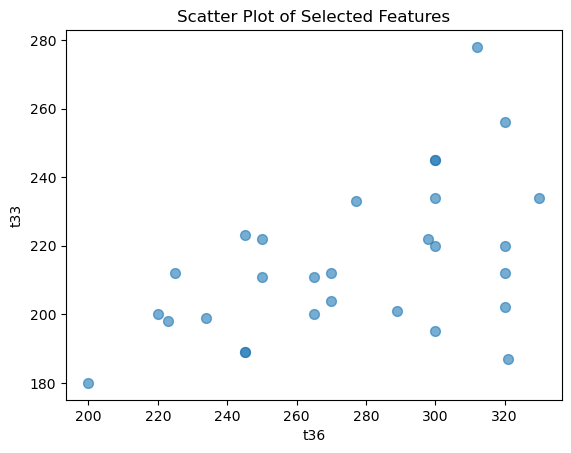

In [36]:
build_scatter_plot(data, feature_x, feature_y)

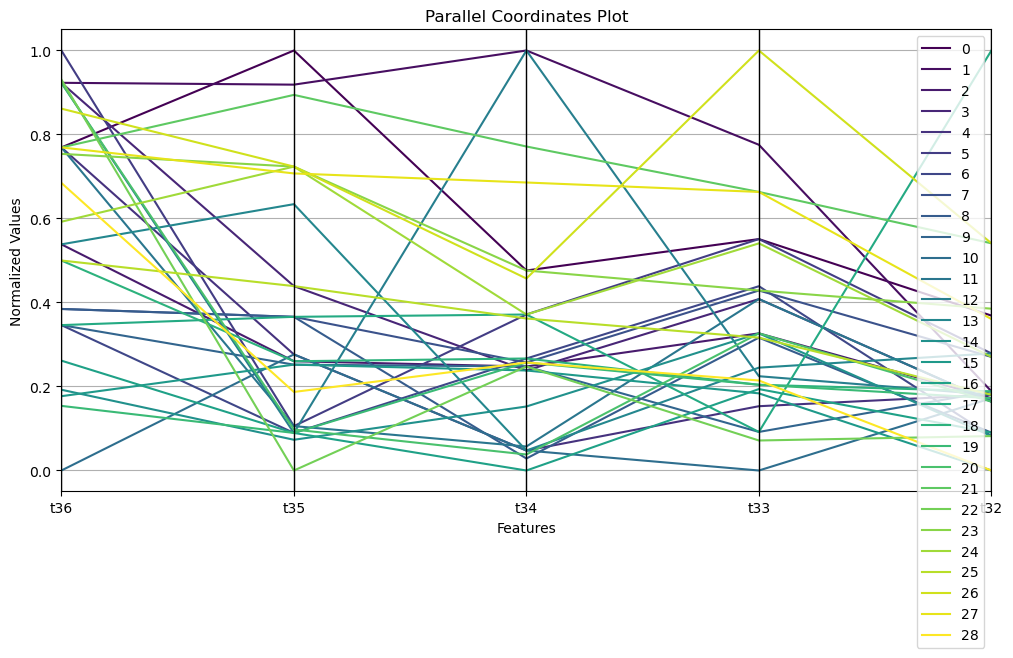

In [37]:
from pandas.plotting import parallel_coordinates

def parallel_coordinates_plot(data):
    normalized_data = MinMaxScaler().fit_transform(data)
    norm_df = pd.DataFrame(normalized_data, columns=data.columns)
    norm_df["Index"] = range(len(data))  # Add an index column for the plot
    
    plt.figure(figsize=(12, 6))
    parallel_coordinates(norm_df, "Index", colormap='viridis')
    plt.title("Parallel Coordinates Plot")
    plt.xlabel("Features")
    plt.ylabel("Normalized Values")
    plt.show()

parallel_coordinates_plot(data)

In [40]:
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(data)
    data['Cluster'] = clusters
    return data, kmeans

In [41]:
n_clusters = 4
original_data_copy = data.copy()
clustered_data, kmeans_model = kmeans_clustering(data, n_clusters)
display(clustered_data)

D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,t36,t35,t34,t33,t32,Cluster
0,300,312,245,234,223,1
1,320,302,300,256,201,1
2,270,221,221,212,199,2
3,320,243,220,220,198,0
4,300,223,200,195,200,0
5,330,202,234,234,212,0
6,245,200,223,223,188,2
7,250,234,222,222,211,2
8,250,234,198,211,189,2
9,245,220,221,189,201,2


In [42]:
def calculate_cluster_means(data, cluster_col):
    cluster_means = data.groupby(cluster_col).mean()
    return cluster_means

In [43]:
cluster_means = calculate_cluster_means(clustered_data, 'Cluster')
print("Cluster Means:")
display(cluster_means)

Cluster Means:


,t36,t35,t34,t33,t32
Cluster,,,,,
0,312.500000,209.000000,224.625000,208.875000,196.500000
1,301.000000,289.000000,258.571429,244.714286,224.285714
2,243.230769,221.615385,214.538462,204.692308,196.461538
3,245.000000,234.000000,234.000000,189.000000,300.000000


In [44]:
def hierarchical_clustering(data):
    linkage_matrix = linkage(data, method='ward')
    return linkage_matrix

In [45]:
def display_linkage_matrix(linkage_matrix):
    linkage_df = pd.DataFrame(
        linkage_matrix,
        columns=["Cluster 1", "Cluster 2", "Distance", "Observations"]
    )
    display(linkage_df)

In [46]:
from scipy.spatial.distance import squareform

def display_linkage_as_matrix(linkage_matrix, labels=None):
    # Convert the condensed linkage matrix to a square distance matrix
    distance_matrix = squareform(linkage_matrix[:, 2])  # Extract distances
    
    # Create labels if none provided
    if labels is None:
        labels = [f"Cluster {i}" for i in range(len(distance_matrix))]
    
    # Create a DataFrame for better visualization
    distance_df = pd.DataFrame(distance_matrix, index=labels, columns=labels)
    
    return distance_df

In [47]:
linkage_matrix = hierarchical_clustering(original_data_copy.copy())
display_linkage_matrix(linkage_matrix)

,Cluster 1,Cluster 2,Distance,Observations
0,2.0,18.0,13.304135,2.0
1,14.0,19.0,20.371549,2.0
2,11.0,20.0,21.656408,2.0
3,7.0,25.0,25.865034,2.0
4,23.0,24.0,29.647934,2.0
5,16.0,30.0,29.771351,3.0
6,9.0,29.0,32.624122,3.0
7,21.0,27.0,33.075671,2.0
8,15.0,34.0,34.207699,4.0
9,4.0,28.0,35.298725,2.0


In [48]:
distance_df = display_linkage_as_matrix(linkage_matrix)
display(distance_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
Cluster 0,0.000000,13.304135,20.371549,21.656408,25.865034,29.647934,29.771351,32.624122
Cluster 1,13.304135,0.000000,33.075671,34.207699,35.298725,39.034600,39.386123,40.674316
Cluster 2,20.371549,33.075671,0.000000,43.355123,45.216148,48.038526,48.672374,54.851314
Cluster 3,21.656408,34.207699,43.355123,0.000000,60.738315,61.260101,68.992753,70.238980
Cluster 4,25.865034,35.298725,45.216148,60.738315,0.000000,82.485208,115.912837,117.881669
Cluster 5,29.647934,39.034600,48.038526,61.260101,82.485208,0.000000,146.151773,228.430458
Cluster 6,29.771351,39.386123,48.672374,68.992753,115.912837,146.151773,0.000000,322.385507
Cluster 7,32.624122,40.674316,54.851314,70.238980,117.881669,228.430458,322.385507,0.000000


In [49]:
def plot_dendrogram(linkage_matrix):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=10)
    plt.title("Dendrogram (Ward's Method)")
    plt.xlabel("Sample Index or Cluster Size")
    plt.ylabel("Distance")
    plt.show()

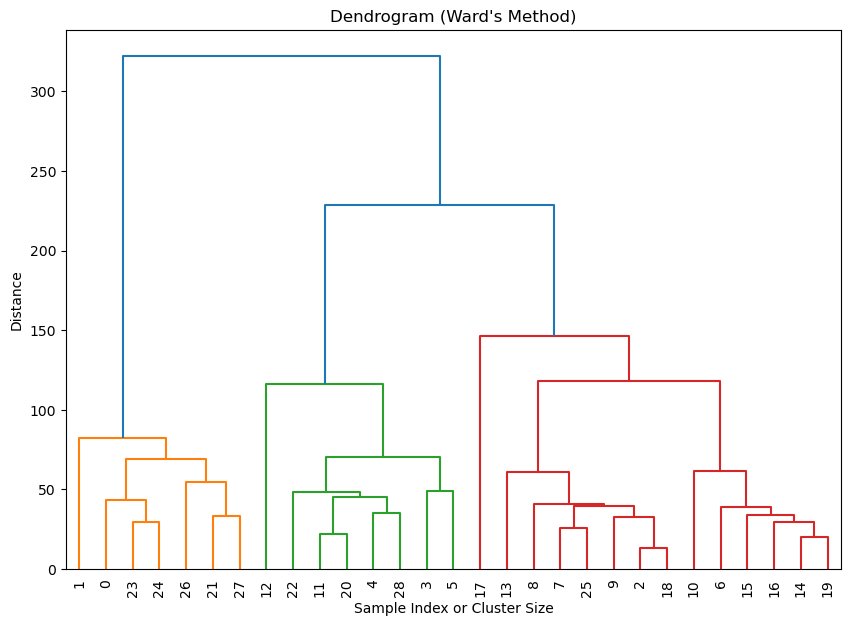

In [50]:
plot_dendrogram(linkage_matrix)

In [51]:
def scatter_plot_clusters(data, feature_x, feature_y, cluster_col):
    plt.scatter(data[feature_x], data[feature_y], c=data[cluster_col], cmap='viridis', s=50, alpha=0.6)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title("Clustered Data (Scatter Plot)")
    plt.colorbar(label='Cluster')
    plt.show()

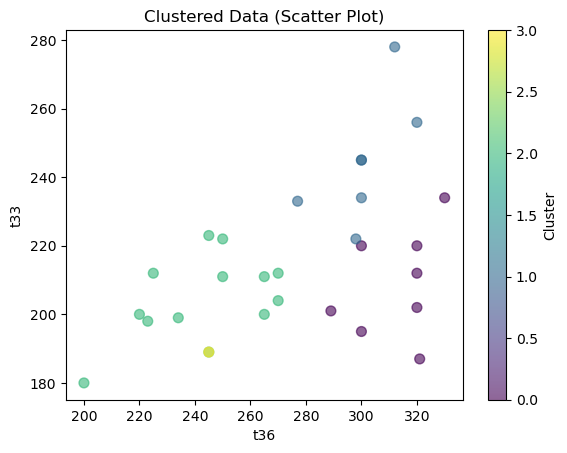

In [52]:
scatter_plot_clusters(clustered_data, feature_x, feature_y, 'Cluster')

In [53]:
def parallel_coordinates_clusters(data, cluster_col):
    plt.figure(figsize=(12, 6))
    parallel_coordinates(data, cluster_col, colormap='viridis')
    plt.title("Clustered Data (Parallel Coordinates Plot)")
    plt.show()

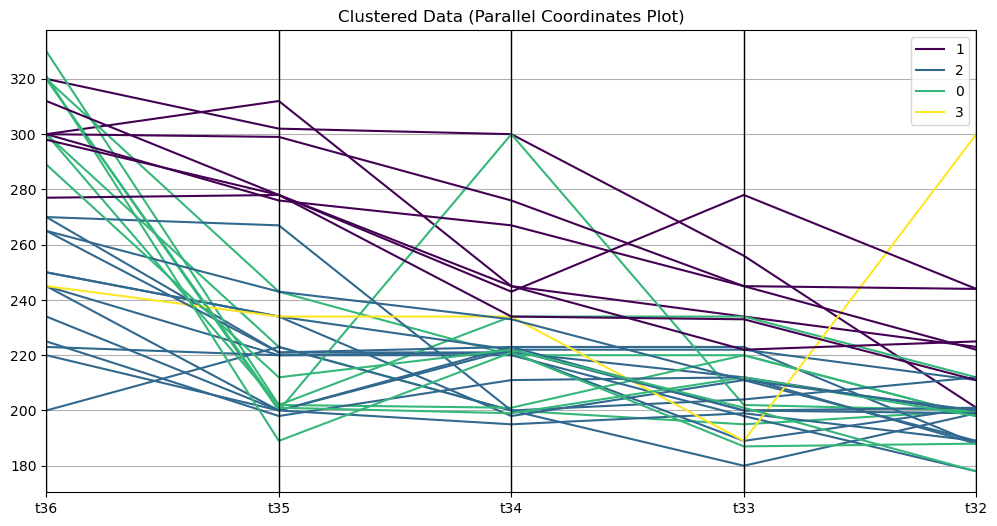

In [54]:
parallel_coordinates_clusters(clustered_data, 'Cluster')

In [55]:
def calculate_dunn_index(data, clusters):
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    
    if num_clusters < 2:
        raise ValueError("Dunn Index requires at least two clusters.")
    
    # Inter-cluster distances
    inter_distances = []
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            cluster_i = data[clusters == unique_clusters[i]]
            cluster_j = data[clusters == unique_clusters[j]]
            if cluster_i.size > 0 and cluster_j.size > 0:
                dist = np.min(pairwise_distances(cluster_i, cluster_j))
                inter_distances.append(dist)
    
    # Intra-cluster distances
    intra_distances = []
    for cluster in unique_clusters:
        cluster_points = data[clusters == cluster]
        if len(cluster_points) > 1:
            dist = np.max(pairwise_distances(cluster_points, cluster_points))
        else:
            dist = 0  # Single-point cluster
        intra_distances.append(dist)
    
    # Avoid division by zero
    if np.max(intra_distances) == 0:
        return np.inf  # Perfectly compact clusters
    
    # Calculate Dunn Index
    return np.min(inter_distances) / np.max(intra_distances)

In [56]:
scaled_data = MinMaxScaler().fit_transform(original_data_copy.iloc[:, :-1])
dunn_for_current_clustering = calculate_dunn_index(scaled_data, kmeans_model.labels_)
print(f"Dunn Index for {n_clusters} clusters: {dunn_for_current_clustering}")

Dunn Index for 4 clusters: 0.2666693658392391


In [57]:
results = []
for k in range(2, 10):
    _, kmeans_model = kmeans_clustering(data, k)
    dunn = calculate_dunn_index(scaled_data, kmeans_model.labels_)
    results.append((k, dunn))

D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

,Number of Clusters,Dunn Index
0,2,0.283364
1,3,0.254264
2,4,0.266669
3,5,0.194426
4,6,0.246409
5,7,0.246409
6,8,0.413666
7,9,0.413666


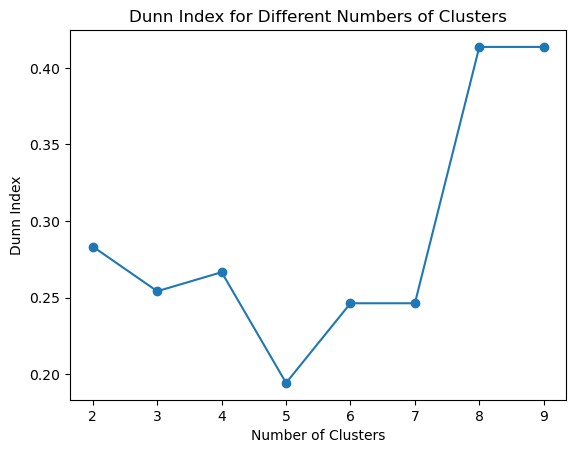

In [58]:
dunn_df = pd.DataFrame(results, columns=['Number of Clusters', 'Dunn Index'])
display(dunn_df)

# Plot results
plt.plot(dunn_df['Number of Clusters'], dunn_df['Dunn Index'], marker='o')
plt.title("Dunn Index for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Dunn Index")
plt.show()